# CKD Risk Prediction: Comparative Analysis
## Real-Only Model vs. Real + Synthetic Augmented Model

This notebook compares two scenarios using a **single canonical feature representation** (no one-hot flags, no scaled feature snapshots):
- **Real Only**: train/evaluate using real training data only
- **Real + Synthetic (Augmented)**: train using real + fold-local synthetic samples, evaluate on real validation folds

**Canonical feature set (exact order):** `['hemo','sc','al','htn','age','dm']`

Primary reporting in this notebook uses **5-fold cross-validation (CV)**:
- Summary table uses **CV mean ± std** metrics
- Plots use **CV out-of-fold predictions** (ROC + confusion matrices)

A **purely real holdout test set** can still be loaded for optional checks, but the main comparison in this notebook focuses on leakage-safe CV.

---

### Analysis Goals
- Load pretrained model trained on real data (canonical schema)
- Train a new model on augmented data (real + fold-local synthetic)
- Compare **CV performance metrics** between scenarios
- Generate visualizations (CV metrics, CV ROC curves, CV confusion matrices)
- Print and save a comparative CV metrics table


## 1. Imports, Paths, and Configuration


In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
 )

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional dependency (only needed if you run XGB)
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None

# Ensure project root is importable (so `import src.*` works from /notebooks)
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.canonical import (
    CANONICAL_FEATURES,
    assert_canonical_schema,
    forbid_onehot_residuals,
 )
from src.synthesizer import GaussianCopulaGenerator, postprocess_synth

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported.")

Libraries imported.


In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    # Canonical preprocessed (real) train/test
    'X_train_preproc_path': '../data/processed/preprocessed/X_train_preproc.csv',
    'X_test_preproc_path': '../data/processed/preprocessed/X_test_preproc.csv',
    # Canonical preprocessed synthetic (only used for training a final augmented model, not for CV)
    'X_synth_path': '../data/synthetic/X_synth_3x_gcopula_preproc.csv',

    # Labels
    'y_train_path': '../data/processed/splits/y_train.csv',
    'y_test_path': '../data/processed/splits/y_test.csv',
    'y_synth_path': '../data/synthetic/y_synth_3x_gcopula.csv',

    # Pretrained model paths (Real Only models)
    'model_lr_real_path': '../models/lr.joblib',
    'model_rf_real_path': '../models/rf.joblib',
    'model_xgb_real_path': '../models/xgb.joblib',
}

# ============================================================================
# EXPERIMENT SETTINGS
# ============================================================================
MODEL_NAMES = ['lr', 'rf', 'xgb']  # extendable
RANDOM_STATE = 42
CV_FOLDS = 5

# Leakage-safe augmented CV uses fold-local synthesis (gcopula)
AUGMENT_MULTIPLIER = 3
SYNTH_BACKEND = 'gcopula'

print("Configuration loaded.")
print(f"Canonical features: {CANONICAL_FEATURES}")
print(f"Models to run: {[m.upper() for m in MODEL_NAMES]}")
print(f"CV folds: {CV_FOLDS}")
print(f"Random state: {RANDOM_STATE}")
print(f"Augmented CV: fold-local {SYNTH_BACKEND} @ {AUGMENT_MULTIPLIER}x")

Configuration loaded.
Canonical features: ['hemo', 'sc', 'al', 'htn', 'age', 'dm']
Models to run: ['LR', 'RF', 'XGB']
CV folds: 5
Random state: 42
Augmented CV: fold-local gcopula @ 3x


## 2. Load Real Train & Test Features + Labels
(Canonical preprocessed schema; no one-hot encoded clinical flags.)


In [3]:
def read_y_csv(path: str | None) -> pd.Series:
    if not path:
        raise ValueError(
            "y path not provided. Set CONFIG['y_train_path'] / CONFIG['y_test_path'] / CONFIG['y_synth_path']."
        )

    # Robust read: handle both headerless single-column CSV and CSV with a header.
    y_df = pd.read_csv(path, header=None)
    if y_df.shape[1] == 0:
        raise ValueError(f"No columns found in label file: {path}")

    y = y_df.iloc[:, 0]

    # Drop a header-like first row if present
    if y.dtype == object and len(y) > 0:
        first = str(y.iloc[0]).strip().lower()
        if first in {'label', 'labels', 'target', 'y', 'class', 'classification'}:
            y = y.iloc[1:]

    return y.reset_index(drop=True)


def normalize_binary_y(y: pd.Series) -> pd.Series:
    y = y.copy()

    # If it's already numeric 0/1, keep it.
    if pd.api.types.is_numeric_dtype(y):
        unique_vals = set(pd.unique(y.dropna()))
        if unique_vals.issubset({0, 1}):
            return y.astype(int)
        return y

    # Otherwise map common CKD label strings
    y_str = y.astype(str).str.strip().str.lower()
    mapping = {
        'ckd': 1,
        'notckd': 0,
        'yes': 1,
        'no': 0,
        '1': 1,
        '0': 0,
        'true': 1,
        'false': 0,
    }
    y_mapped = y_str.map(mapping)
    if y_mapped.isna().any():
        bad = sorted(set(y_str[y_mapped.isna()].unique()))
        raise ValueError(
            "Unrecognized label values in y. Provide numeric 0/1 labels or update mapping. "
            f"Bad values: {bad[:10]}"
        )
    return y_mapped.astype(int)


def read_x_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Only drop completely empty rows (common when CSV has trailing newlines)
    return df.dropna(how='all').reset_index(drop=True)


# The exact 6 canonical features used everywhere
FEAT_6 = CANONICAL_FEATURES.copy()

# 1) Load canonical preprocessed real train/test
X_train = read_x_csv(CONFIG['X_train_preproc_path'])
X_test = read_x_csv(CONFIG['X_test_preproc_path'])
print(f"Loaded X_train (preproc, canonical): {X_train.shape}")
print(f"Loaded X_test  (preproc, canonical): {X_test.shape}")

# 2) Labels
y_train = normalize_binary_y(read_y_csv(CONFIG.get('y_train_path')))
y_test = normalize_binary_y(read_y_csv(CONFIG.get('y_test_path')))

# Basic alignment checks
if len(X_train) != len(y_train):
    raise ValueError(f"X_train and y_train length mismatch: {len(X_train)} vs {len(y_train)}")
if len(X_test) != len(y_test):
    raise ValueError(f"X_test and y_test length mismatch: {len(X_test)} vs {len(y_test)}")

# Canonical schema enforcement
forbid_onehot_residuals(list(X_train.columns))
forbid_onehot_residuals(list(X_test.columns))

missing = sorted(set(FEAT_6) - set(X_train.columns))
if missing:
    raise ValueError(f"X_train missing required canonical columns: {missing}")
missing = sorted(set(FEAT_6) - set(X_test.columns))
if missing:
    raise ValueError(f"X_test missing required canonical columns: {missing}")

# Strict subset + order
X_train = X_train[FEAT_6].copy()
X_test = X_test[FEAT_6].copy()
assert_canonical_schema(X_train)
assert_canonical_schema(X_test)

print("Real data loaded in canonical schema.")

Loaded X_train (preproc, canonical): (280, 6)
Loaded X_test  (preproc, canonical): (120, 6)
Real data loaded in canonical schema.


## 3. Load Synthetic Features + Labels (for Augmented Training Only)


In [4]:
# Load synthetic PREPROCESSED features (used for training a final augmented model)
X_synth = read_x_csv(CONFIG['X_synth_path'])
print(f"Loaded X_synth: {X_synth.shape}")

# Synthetic labels
y_synth = normalize_binary_y(read_y_csv(CONFIG.get('y_synth_path')))

if len(X_synth) != len(y_synth):
    raise ValueError(f"X_synth and y_synth length mismatch: {len(X_synth)} vs {len(y_synth)}")

# Canonical schema enforcement
forbid_onehot_residuals(list(X_synth.columns))
missing = sorted(set(FEAT_6) - set(X_synth.columns))
if missing:
    raise ValueError(f"X_synth missing required canonical columns: {missing}")

X_synth = X_synth[FEAT_6].copy()
assert_canonical_schema(X_synth)

print("Synthetic training data loaded in canonical schema.")

Loaded X_synth: (840, 6)
Synthetic training data loaded in canonical schema.


## 4. Schema & Column Alignment Checks (Canonical Only)


In [5]:
print("Checking canonical schema consistency for real/synth...")

for name, df in [
    ('X_train', X_train),
    ('X_test', X_test),
    ('X_synth', X_synth),
 ]:
    forbid_onehot_residuals(list(df.columns))
    assert_canonical_schema(df)
    nan_count = int(df.isna().sum().sum())
    inf_count = int(np.isinf(df.to_numpy(dtype=float)).sum())
    print(f"- {name}: shape={df.shape}, NaNs={nan_count}, Infs={inf_count}")
    if nan_count or inf_count:
        print("  NOTE: canonical preprocessed data is expected to be fully numeric and imputed.")

# Extra sanity: all columns should be numeric
non_numeric = {
    'X_train': X_train.select_dtypes(exclude=[np.number]).columns.tolist(),
    'X_test': X_test.select_dtypes(exclude=[np.number]).columns.tolist(),
    'X_synth': X_synth.select_dtypes(exclude=[np.number]).columns.tolist(),
}
bad = {k: v for k, v in non_numeric.items() if v}
if bad:
    raise ValueError(f"Non-numeric columns found (expected numeric-only): {bad}")

print("Schema checks complete.")

Checking canonical schema consistency for real/synth...
- X_train: shape=(280, 6), NaNs=0, Infs=0
- X_test: shape=(120, 6), NaNs=0, Infs=0
- X_synth: shape=(840, 6), NaNs=0, Infs=0
Schema checks complete.


## 5. Load Pretrained "Real Only" Model


In [6]:
model_paths = {
    'lr': CONFIG['model_lr_real_path'],
    'rf': CONFIG['model_rf_real_path'],
    'xgb': CONFIG['model_xgb_real_path'],
}

# Load all pretrained (real-only) models requested
model_real_by_name = {}

X_test_6 = X_test[FEAT_6]
assert_canonical_schema(X_test_6)

for model_name in MODEL_NAMES:
    if model_name not in model_paths:
        raise ValueError(f"Model '{model_name}' not supported. Available: {sorted(model_paths.keys())}")

    model_path = model_paths[model_name]
    print(f"Loading pretrained {model_name.upper()} model (trained on REAL data, canonical schema)...")
    model_real = joblib.load(model_path)
    model_real_by_name[model_name] = model_real
    print(f"  Loaded from: {model_path}")

    # Validate model using canonical test data
    try:
        _ = model_real.predict(X_test_6)
        print("  OK: predicts on canonical X_test")
    except Exception as e:
        raise RuntimeError(
            f"Pretrained {model_name.upper()} model validation failed on canonical input. "
            "This indicates the saved model is not compatible with the canonical schema. "
            "If these models were trained before the canonical refactor, retrain via: python src/train.py --variant baseline "
            f"Error: {e}"
        )

print("All pretrained models loaded and validated on canonical input.")

Loading pretrained LR model (trained on REAL data, canonical schema)...
  Loaded from: ../models/lr.joblib
  OK: predicts on canonical X_test
Loading pretrained RF model (trained on REAL data, canonical schema)...
  Loaded from: ../models/rf.joblib
  OK: predicts on canonical X_test
Loading pretrained XGB model (trained on REAL data, canonical schema)...
  Loaded from: ../models/xgb.joblib
  OK: predicts on canonical X_test
All pretrained models loaded and validated on canonical input.


## 6. Build Augmented Training Set (Real + Synthetic)


In [7]:
# Build augmented training set (canonical schema)
if X_train is None or X_synth is None:
    raise ValueError("X_train or X_synth is None. Check data loading steps.")
if y_train is None or y_synth is None:
    raise ValueError("y_train or y_synth is None. Check label loading steps.")

X_parts = [X_train, X_synth]
y_parts = [y_train, y_synth]

X_aug = pd.concat(X_parts, axis=0, ignore_index=True)
y_aug = pd.concat(y_parts, axis=0, ignore_index=True)

# Ensure labels are a clean 1D Series
y_aug = pd.Series(y_aug).reset_index(drop=True)

assert_canonical_schema(X_aug[FEAT_6])

print("Augmented training set created:")
print(f"- Real samples:      {len(X_train)}")
print(f"- Synthetic samples: {len(X_synth)}")
print(f"- Total samples:     {len(X_aug)}")
print(f"- X_aug: {X_aug.shape}, y_aug: {y_aug.shape}")

X_aug, y_aug = shuffle(X_aug, y_aug, random_state=RANDOM_STATE)
print(f"Augmented dataset shuffled (random_state={RANDOM_STATE}).")

Augmented training set created:
- Real samples:      280
- Synthetic samples: 840
- Total samples:     1120
- X_aug: (1120, 6), y_aug: (1120,)
Augmented dataset shuffled (random_state=42).


## 7. Train Augmented Model (Real + Synthetic)


In [8]:
def make_augmented_estimator(model_name: str):
    """Create a fresh estimator for canonical 6-feature training."""
    if model_name == 'lr':
        return LogisticRegression(
            solver='liblinear',
            C=1.0,
            max_iter=1000,
            random_state=RANDOM_STATE,
        )
    if model_name == 'rf':
        return RandomForestClassifier(
            n_estimators=200,
            max_depth=7,
            random_state=RANDOM_STATE,
        )
    if model_name == 'xgb':
        if XGBClassifier is None:
            raise ImportError("xgboost is not installed. Run: %pip install xgboost")
        return XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
        )
    raise ValueError(f"Unsupported model_name: {model_name}")

from pathlib import Path

def _unique_path(path: Path) -> Path:
    if not path.exists():
        return path
    i = 1
    while True:
        cand = path.with_name(f"{path.stem}_v{i}{path.suffix}")
        if not cand.exists():
            return cand
        i += 1

print("Training augmented models on Real + Synthetic canonical data...")
model_augmented_by_name = {}

models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)
tag = f"augmented_{RANDOM_STATE}"

for model_name in MODEL_NAMES:
    model = make_augmented_estimator(model_name)
    model.fit(X_aug[FEAT_6], y_aug)
    model_augmented_by_name[model_name] = model
    print(f"- {model_name.upper()}: trained on {len(X_aug)} rows.")

    out_path = _unique_path(models_dir / f"{model_name}_{tag}.joblib")
    joblib.dump(model, out_path)
    print(f"  Saved: {out_path}")

bundle_path = _unique_path(models_dir / f"models_{tag}.joblib")
joblib.dump(model_augmented_by_name, bundle_path)
print(f"Saved model bundle: {bundle_path}")

Training augmented models on Real + Synthetic canonical data...
- LR: trained on 1120 rows.
  Saved: ..\models\lr_augmented_42_v1.joblib
- RF: trained on 1120 rows.
  Saved: ..\models\rf_augmented_42_v1.joblib
- XGB: trained on 1120 rows.
  Saved: ..\models\xgb_augmented_42_v1.joblib
Saved model bundle: ..\models\models_augmented_42_v1.joblib


## 8. Cross-Validated Evaluation 


In [9]:
print("Running leakage-safe 5-fold CV for each model (OOF ROC + confusion + mean±std metrics)...\n")

SCENARIOS = ['Real Only', f"Real + Synthetic (fold-local {SYNTH_BACKEND}, {AUGMENT_MULTIPLIER}x)"]

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

y_train_np = np.asarray(y_train).astype(int).ravel()

def _predict_score(estimator, X: pd.DataFrame) -> np.ndarray:
    """Continuous scores for ROC-AUC/ROC curve."""
    if hasattr(estimator, 'predict_proba'):
        proba = estimator.predict_proba(X)
        proba = np.asarray(proba)
        return proba[:, 1] if proba.ndim == 2 and proba.shape[1] >= 2 else proba.ravel()
    if hasattr(estimator, 'decision_function'):
        return np.asarray(estimator.decision_function(X)).ravel()
    return np.asarray(estimator.predict(X)).astype(float).ravel()

def _fold_metric_dict(y_true: np.ndarray, y_pred: np.ndarray, y_score: np.ndarray) -> dict:
    out = {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
    }
    try:
        out['roc_auc'] = float(roc_auc_score(y_true, y_score))
    except Exception:
        out['roc_auc'] = float('nan')
    return out

def _summarize_folds(fold_metrics: list[dict]) -> dict:
    df = pd.DataFrame(fold_metrics)
    out = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        vals = df[metric].to_numpy(dtype=float)
        out[f'{metric}_mean'] = float(np.nanmean(vals))
        out[f'{metric}_std'] = float(np.nanstd(vals, ddof=1)) if len(vals) > 1 else 0.0
    return out

def synthesize_fold_gcopula(
    X_train_canon: pd.DataFrame,
    y_train_fold: np.ndarray,
    multiplier: int,
    seed: int,
 ) -> tuple[pd.DataFrame, np.ndarray]:
    """Fold-local synthesis in canonical feature space (leakage-safe)."""
    assert_canonical_schema(X_train_canon)
    forbid_onehot_residuals(list(X_train_canon.columns))

    n_total = int(len(X_train_canon) * int(multiplier))
    if n_total <= 0:
        raise ValueError('multiplier must yield at least 1 synthetic sample')

    rng = np.random.default_rng(int(seed))

    X0 = X_train_canon[y_train_fold == 0].reset_index(drop=True)
    X1 = X_train_canon[y_train_fold == 1].reset_index(drop=True)
    if len(X0) == 0 or len(X1) == 0:
        raise ValueError('Cannot synthesize per-class: one class has zero samples in this fold.')

    p1 = float(len(X1) / len(y_train_fold))
    n1 = int(round(n_total * p1))
    n0 = int(n_total - n1)
    if n0 <= 0 or n1 <= 0:
        n0 = max(1, n0)
        n1 = max(1, n_total - n0)

    cop0 = GaussianCopulaGenerator()
    cop0.fit(X0)
    Xs0 = cop0.sample(n0, seed=int(seed))

    cop1 = GaussianCopulaGenerator()
    cop1.fit(X1)
    Xs1 = cop1.sample(n1, seed=int(seed) + 1)

    Xs = pd.concat([Xs0, Xs1], ignore_index=True)
    ys = np.concatenate([np.zeros(n0, dtype=int), np.ones(n1, dtype=int)])

    perm = rng.permutation(len(Xs))
    Xs = Xs.iloc[perm].reset_index(drop=True)
    ys = ys[perm]

    # Postprocess bounds + binary flags, enforce strict schema/order
    Xs = postprocess_synth(Xs, X_train_canon)
    Xs = Xs[FEAT_6].copy()
    assert_canonical_schema(Xs)
    forbid_onehot_residuals(list(Xs.columns))

    return Xs, ys

def evaluate_oof(y_true: np.ndarray, y_pred: np.ndarray, y_score: np.ndarray) -> dict:
    out = {
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'y_pred': y_pred,
        'y_score': y_score,
    }
    try:
        out['roc_auc'] = float(roc_auc_score(y_true, y_score))
        fpr, tpr, _ = roc_curve(y_true, y_score)
        out['roc_curve'] = {'fpr': fpr, 'tpr': tpr}
    except Exception:
        out['roc_auc'] = float('nan')
        out['roc_curve'] = {'fpr': np.array([0.0, 1.0]), 'tpr': np.array([0.0, 1.0])}
    return out

# Outputs
cv_results = {}   # mean/std from fold metrics
oof_results = {}  # evaluation from out-of-fold predictions
roc_data = {}     # CV-based ROC curve data (from OOF predictions)

X_train_6 = X_train[FEAT_6].copy()
assert_canonical_schema(X_train_6)

for model_name in MODEL_NAMES:
    print(f"{'='*80}\nMODEL: {model_name.upper()}\n{'='*80}")

    # --------------------
    # Scenario A: Real Only
    # --------------------
    oof_pred_real = np.empty(len(y_train_np), dtype=int)
    oof_score_real = np.empty(len(y_train_np), dtype=float)
    fold_metrics_real = []

    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(X_train_6, y_train_np)):
        X_tr = X_train_6.iloc[tr_idx]
        y_tr = y_train_np[tr_idx]
        X_va = X_train_6.iloc[va_idx]
        y_va = y_train_np[va_idx]

        est = clone(model_real_by_name[model_name])
        est.fit(X_tr, y_tr)

        y_pred = np.asarray(est.predict(X_va)).astype(int).ravel()
        y_score = _predict_score(est, X_va)
        oof_pred_real[va_idx] = y_pred
        oof_score_real[va_idx] = y_score
        fold_metrics_real.append(_fold_metric_dict(y_va, y_pred, y_score))

    real_cv_sum = _summarize_folds(fold_metrics_real)
    cv_results[(model_name, SCENARIOS[0])] = real_cv_sum
    real_oof = evaluate_oof(y_train_np, oof_pred_real, oof_score_real)
    oof_results[(model_name, SCENARIOS[0])] = real_oof
    roc_data[(model_name, SCENARIOS[0])] = {
        'fpr': real_oof['roc_curve']['fpr'],
        'tpr': real_oof['roc_curve']['tpr'],
        'auc': real_oof['roc_auc'],
    }

    print("5-fold CV metrics (Real Only):")
    print(
        f"  Mean±Std | Acc={real_cv_sum['accuracy_mean']:.4f}±{real_cv_sum['accuracy_std']:.4f}  "
        f"Prec={real_cv_sum['precision_mean']:.4f}±{real_cv_sum['precision_std']:.4f}  "
        f"Rec={real_cv_sum['recall_mean']:.4f}±{real_cv_sum['recall_std']:.4f}  "
        f"F1={real_cv_sum['f1_mean']:.4f}±{real_cv_sum['f1_std']:.4f}  "
        f"AUC={real_cv_sum['roc_auc_mean']:.4f}±{real_cv_sum['roc_auc_std']:.4f}"
    )

    # --------------------
    # Scenario B: Augmented (fold-local synth from fold-train only)
    # --------------------
    oof_pred_aug = np.empty(len(y_train_np), dtype=int)
    oof_score_aug = np.empty(len(y_train_np), dtype=float)
    fold_metrics_aug = []

    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(X_train_6, y_train_np)):
        X_tr = X_train_6.iloc[tr_idx].reset_index(drop=True)
        y_tr = y_train_np[tr_idx]
        X_va = X_train_6.iloc[va_idx]
        y_va = y_train_np[va_idx]

        if SYNTH_BACKEND != 'gcopula':
            raise ValueError(f"Only gcopula is supported here. Got {SYNTH_BACKEND!r}.")

        fold_seed = int(RANDOM_STATE) * 10_000 + int(fold_idx)
        Xs, ys = synthesize_fold_gcopula(X_tr, y_tr, multiplier=AUGMENT_MULTIPLIER, seed=fold_seed)
        X_fit = pd.concat([X_tr, Xs], ignore_index=True)
        y_fit = np.concatenate([y_tr, ys])
        assert_canonical_schema(X_fit[FEAT_6])

        est = make_augmented_estimator(model_name)
        est.fit(X_fit[FEAT_6], y_fit)

        y_pred = np.asarray(est.predict(X_va)).astype(int).ravel()
        y_score = _predict_score(est, X_va)
        oof_pred_aug[va_idx] = y_pred
        oof_score_aug[va_idx] = y_score
        fold_metrics_aug.append(_fold_metric_dict(y_va, y_pred, y_score))

    aug_cv_sum = _summarize_folds(fold_metrics_aug)
    cv_results[(model_name, SCENARIOS[1])] = aug_cv_sum
    aug_oof = evaluate_oof(y_train_np, oof_pred_aug, oof_score_aug)
    oof_results[(model_name, SCENARIOS[1])] = aug_oof
    roc_data[(model_name, SCENARIOS[1])] = {
        'fpr': aug_oof['roc_curve']['fpr'],
        'tpr': aug_oof['roc_curve']['tpr'],
        'auc': aug_oof['roc_auc'],
    }

    print(f"5-fold CV metrics ({SCENARIOS[1]}):")
    print(
        f"  Mean±Std | Acc={aug_cv_sum['accuracy_mean']:.4f}±{aug_cv_sum['accuracy_std']:.4f}  "
        f"Prec={aug_cv_sum['precision_mean']:.4f}±{aug_cv_sum['precision_std']:.4f}  "
        f"Rec={aug_cv_sum['recall_mean']:.4f}±{aug_cv_sum['recall_std']:.4f}  "
        f"F1={aug_cv_sum['f1_mean']:.4f}±{aug_cv_sum['f1_std']:.4f}  "
        f"AUC={aug_cv_sum['roc_auc_mean']:.4f}±{aug_cv_sum['roc_auc_std']:.4f}"
    )

print("\nCV evaluation complete.")

Running leakage-safe 5-fold CV for each model (OOF ROC + confusion + mean±std metrics)...

MODEL: LR
5-fold CV metrics (Real Only):
  Mean±Std | Acc=0.9536±0.0160  Prec=0.9943±0.0128  Rec=0.9314±0.0326  F1=0.9614±0.0141  AUC=0.9913±0.0081
5-fold CV metrics (Real + Synthetic (fold-local gcopula, 3x)):
  Mean±Std | Acc=0.9536±0.0160  Prec=0.9943±0.0128  Rec=0.9314±0.0326  F1=0.9614±0.0141  AUC=0.9935±0.0063
MODEL: RF
5-fold CV metrics (Real Only):
  Mean±Std | Acc=0.9607±0.0407  Prec=0.9765±0.0252  Rec=0.9600±0.0433  F1=0.9680±0.0336  AUC=0.9951±0.0087
5-fold CV metrics (Real + Synthetic (fold-local gcopula, 3x)):
  Mean±Std | Acc=0.9643±0.0219  Prec=0.9716±0.0202  Rec=0.9714±0.0202  F1=0.9714±0.0175  AUC=0.9946±0.0107
MODEL: XGB
5-fold CV metrics (Real Only):
  Mean±Std | Acc=0.9536±0.0430  Prec=0.9652±0.0248  Rec=0.9600±0.0478  F1=0.9624±0.0353  AUC=0.9916±0.0116
5-fold CV metrics (Real + Synthetic (fold-local gcopula, 3x)):
  Mean±Std | Acc=0.9679±0.0426  Prec=0.9768±0.0251  Rec=0.971

## 9. Comparative Metrics Table (CV Only)


In [10]:
rows = []
for model_name in MODEL_NAMES:
    for scenario in SCENARIOS:
        cv_sum = cv_results.get((model_name, scenario), {})
        row = {
            'Model': model_name.upper(),
            'Scenario': scenario,
            'CV_Accuracy_Mean': cv_sum.get('accuracy_mean', np.nan),
            'CV_Accuracy_Std': cv_sum.get('accuracy_std', np.nan),
            'CV_Precision_Mean': cv_sum.get('precision_mean', np.nan),
            'CV_Precision_Std': cv_sum.get('precision_std', np.nan),
            'CV_Recall_Mean': cv_sum.get('recall_mean', np.nan),
            'CV_Recall_Std': cv_sum.get('recall_std', np.nan),
            'CV_F1_Mean': cv_sum.get('f1_mean', np.nan),
            'CV_F1_Std': cv_sum.get('f1_std', np.nan),
            'CV_ROC_AUC_Mean': cv_sum.get('roc_auc_mean', np.nan),
            'CV_ROC_AUC_Std': cv_sum.get('roc_auc_std', np.nan),
        }
        rows.append(row)

summary_df = pd.DataFrame(rows).set_index(['Model', 'Scenario']).sort_index()

print("\n" + "=" * 100)
print("5-FOLD CV SUMMARY")
print("=" * 100)
display(summary_df.round(4))
print("=" * 100 + "\n")

print("DELTA (Augmented minus Real Only) on CV MEANS:")
print("-" * 90)
for model_name in MODEL_NAMES:
    a = summary_df.loc[(model_name.upper(), SCENARIOS[0])]
    b = summary_df.loc[(model_name.upper(), SCENARIOS[1])]
    print(f"{model_name.upper()}: ", end='')
    print(
        f"Acc {b['CV_Accuracy_Mean']-a['CV_Accuracy_Mean']:+.4f}, ",
        f"Rec {b['CV_Recall_Mean']-a['CV_Recall_Mean']:+.4f}, ",
        f"F1 {b['CV_F1_Mean']-a['CV_F1_Mean']:+.4f}, ",
        f"AUC {b['CV_ROC_AUC_Mean']-a['CV_ROC_AUC_Mean']:+.4f}"
    )
print("-" * 90 + "\n")

metrics_csv_path = '../results/metrics_comparison_all_models.csv'
summary_df.to_csv(metrics_csv_path, index=True)
print(f"Saved CV metrics to: {metrics_csv_path}")


5-FOLD CV SUMMARY


CV_Accuracy_Mean  \
Model Scenario                                                      
LR    Real + Synthetic (fold-local gcopula, 3x)            0.9536   
      Real Only                                            0.9536   
RF    Real + Synthetic (fold-local gcopula, 3x)            0.9643   
      Real Only                                            0.9607   
XGB   Real + Synthetic (fold-local gcopula, 3x)            0.9679   
      Real Only                                            0.9536   

                                                 CV_Accuracy_Std  \
Model Scenario                                                     
LR    Real + Synthetic (fold-local gcopula, 3x)           0.0160   
      Real Only                                           0.0160   
RF    Real + Synthetic (fold-local gcopula, 3x)           0.0219   
      Real Only                                           0.0407   
XGB   Real + Synthetic (fold-local gcopula, 3x)           0.0426   
      Real Only                                           0.0430   

                                                 CV_Precision_Mean  \
Model Scenario                                                       
LR    Real + Synthetic (fold-local gcopula, 3x)             0.9943   
      Real Only                                             0.9943   
RF    Real + Synthetic (fold-local gcopula, 3x)             0.9716   
      Real Only                                             0.9765   
XGB   Real + Synthetic (fold-local gcopula, 3x)             0.9768   
      Real Only                                             0.9652   

                                                 CV_Precision_Std  \
Model Scenario                                                      
LR    Real + Synthetic (fold-local gcopula, 3x)            0.0128   
      Real Only                                            0.0128   
RF    Real + Synthetic (fold-local gcopula, 3x)            0.0202   
      Real Only                                            0.0252   
XGB   Real + Synthetic (fold-local gcopula, 3x)            0.0251   
      Real Only                                            0.0248   

                                                 CV_Recall_Mean  \
Model Scenario                                                    
LR    Real + Synthetic (fold-local gcopula, 3x)          0.9314   
      Real Only                                          0.9314   
RF    Real + Synthetic (fold-local gcopula, 3x)          0.9714   
      Real Only                                          0.9600   
XGB   Real + Synthetic (fold-local gcopula, 3x)          0.9714   
      Real Only                                          0.9600   

                                                 CV_Recall_Std  CV_F1_Mean  \
Model Scenario                                                               
LR    Real + Synthetic (fold-local gcopula, 3x)         0.0326      0.9614   
      Real Only                                         0.0326      0.9614   
RF    Real + Synthetic (fold-local gcopula, 3x)         0.0202      0.9714   
      Real Only                                         0.0433      0.9680   
XGB   Real + Synthetic (fold-local gcopula, 3x)         0.0495      0.9738   
      Real Only                                         0.0478      0.9624   

                                                 CV_F1_Std  CV_ROC_AUC_Mean  \
Model Scenario                                                                
LR    Real + Synthetic (fold-local gcopula, 3x)     0.0141           0.9935   
      Real Only                                     0.0141           0.9913   
RF    Real + Synthetic (fold-local gcopula, 3x)     0.0175           0.9946   
      Real Only                                     0.0336           0.9951   
XGB   Real + Synthetic (fold-local gcopula, 3x)     0.0352           0.9946   
      Real Only                                     0.0353           0.9916   

                                          


DELTA (Augmented minus Real Only) on CV MEANS:
------------------------------------------------------------------------------------------
LR: Acc +0.0000,  Rec +0.0000,  F1 +0.0000,  AUC +0.0022
RF: Acc +0.0036,  Rec +0.0114,  F1 +0.0034,  AUC -0.0005
XGB: Acc +0.0143,  Rec +0.0114,  F1 +0.0114,  AUC +0.0030
------------------------------------------------------------------------------------------

Saved CV metrics to: ../results/metrics_comparison_all_models.csv


## 9B. Load Saved Metrics CSV + Plot Accuracy Only (Real vs Real+Synthetic)


Loaded: ..\results\metrics_comparison_all_models.csv  |  shape=(6, 12)


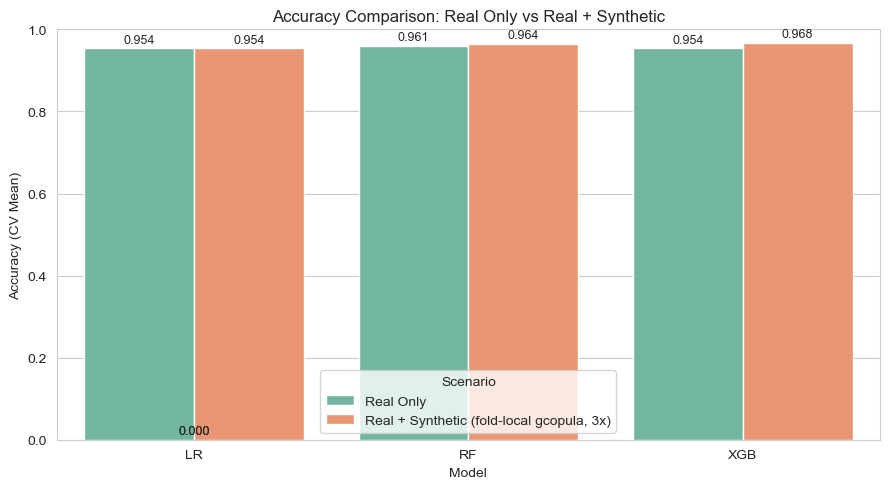

In [3]:
from pathlib import Path

metrics_path = Path("..") / "results" / "metrics_comparison_all_models.csv"
if not metrics_path.exists():
    raise FileNotFoundError(
        f"Could not find {metrics_path}. Run the CV summary cell first (Section 9) to generate it."
    )

df = pd.read_csv(metrics_path)
print(f"Loaded: {metrics_path}  |  shape={df.shape}")

# The CSV is saved with a 2-level index (Model, Scenario). Handle both formats robustly.
if {'Model', 'Scenario'}.issubset(df.columns):
    metrics_df = df.copy()
else:
    # If saved with unnamed index columns
    idx_cols = [c for c in df.columns if c.lower().startswith('unnamed')]
    if len(idx_cols) >= 2:
        metrics_df = df.rename(columns={idx_cols[0]: 'Model', idx_cols[1]: 'Scenario'})
    else:
        raise ValueError(
            "Unexpected CSV format. Expected columns ['Model','Scenario',...] or unnamed index columns."
        )

# Keep accuracy columns
need_cols = ['Model', 'Scenario', 'CV_Accuracy_Mean']
missing = [c for c in need_cols if c not in metrics_df.columns]
if missing:
    raise ValueError(f"Missing required columns in metrics CSV: {missing}. Columns={list(metrics_df.columns)}")

plot_acc = metrics_df[need_cols + ([ 'CV_Accuracy_Std' ] if 'CV_Accuracy_Std' in metrics_df.columns else [])].copy()

# Filter scenarios to just the two we want (Real vs Real+Synthetic)
plot_acc['Scenario'] = plot_acc['Scenario'].astype(str)
keep_mask = plot_acc['Scenario'].str.contains('Real Only', case=False, regex=False) | plot_acc['Scenario'].str.contains('Real + Synthetic', case=False, regex=False)
plot_acc = plot_acc.loc[keep_mask].copy()

# Normalize model names
plot_acc['Model'] = plot_acc['Model'].astype(str).str.upper()

# Order models if possible
model_order = [m.upper() for m in MODEL_NAMES] if 'MODEL_NAMES' in globals() else sorted(plot_acc['Model'].unique())
scenario_order = ['Real Only']
real_plus = [s for s in plot_acc['Scenario'].unique() if 'Real + Synthetic' in s]
if real_plus:
    scenario_order.append(real_plus[0])

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    data=plot_acc,
    x='Model',
    y='CV_Accuracy_Mean',
    hue='Scenario',
    order=model_order,
    hue_order=scenario_order if len(scenario_order) == plot_acc['Scenario'].nunique() else None,
    palette='Set2',
)

ax.set_ylim(0, 1)
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy (CV Mean)")
ax.set_title("Accuracy Comparison: Real Only vs Real + Synthetic")

# Optional error bars (std) if available
if 'CV_Accuracy_Std' in plot_acc.columns:
    # Add error bars aligned to drawn bars
    for container, scenario in zip(ax.containers, ax.get_legend_handles_labels()[1]):
        sub = plot_acc[plot_acc['Scenario'] == scenario].set_index('Model')
        for bar in container:
            model = bar.get_x() + bar.get_width() / 2
        # (Seaborn doesn't give direct mapping; do a simple per-bar loop using the bar's label order)
    # Simple alternative: annotate ±std in text (clean + robust)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:.3f}", (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9, xytext=(0, 2), textcoords='offset points')
else:
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:.3f}", (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9, xytext=(0, 2), textcoords='offset points')

plt.tight_layout()
plt.show()

## 10. Plot 1: Grouped Bar Chart (CV Accuracy, Recall, F1-Score)


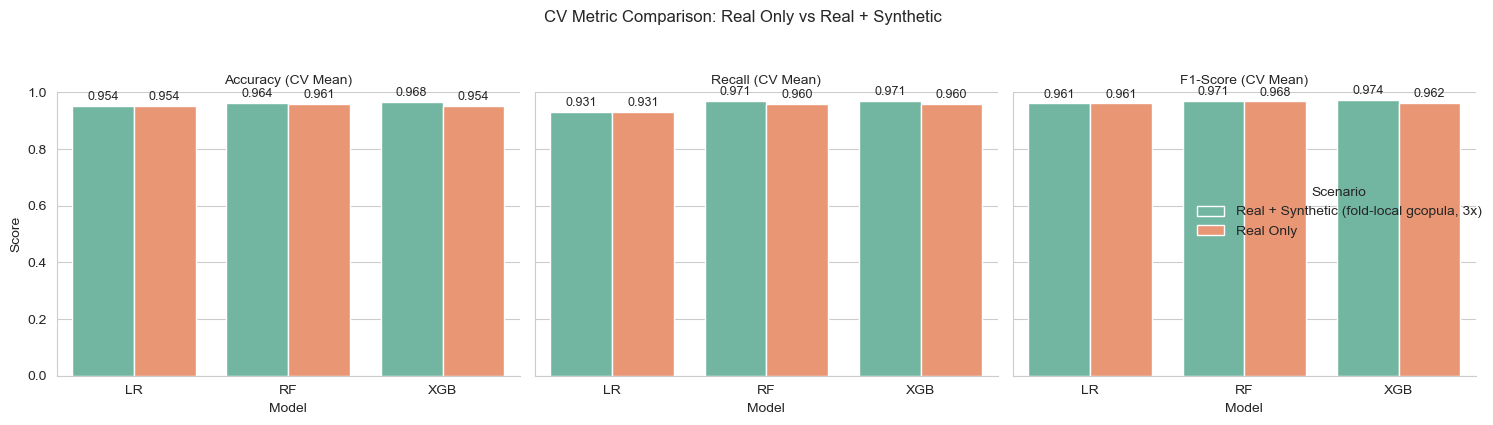

In [11]:
plot_cols = {
    'CV_Accuracy_Mean': 'Accuracy (CV Mean)',
    'CV_Recall_Mean': 'Recall (CV Mean)',
    'CV_F1_Mean': 'F1-Score (CV Mean)',
}

plot_df = summary_df.reset_index()[['Model', 'Scenario'] + list(plot_cols.keys())].copy()
plot_df = plot_df.rename(columns=plot_cols)
plot_df = plot_df.melt(id_vars=['Model', 'Scenario'], var_name='Metric', value_name='Score')

g = sns.catplot(
    data=plot_df,
    x='Model',
    y='Score',
    hue='Scenario',
    col='Metric',
    kind='bar',
    col_wrap=3,
    height=4,
    aspect=1,
    palette='Set2',
    legend_out=True,
)

g.set(ylim=(0, 1))
g.set_axis_labels("Model", "Score")
g.set_titles("{col_name}")
g.fig.suptitle("CV Metric Comparison: Real Only vs Real + Synthetic", y=1.05)

# Add value labels
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=2, fontsize=9)

plt.tight_layout()
plt.show()

## 11. Plot 2: ROC Curve Overlay (CV Out-of-Fold Predictions)


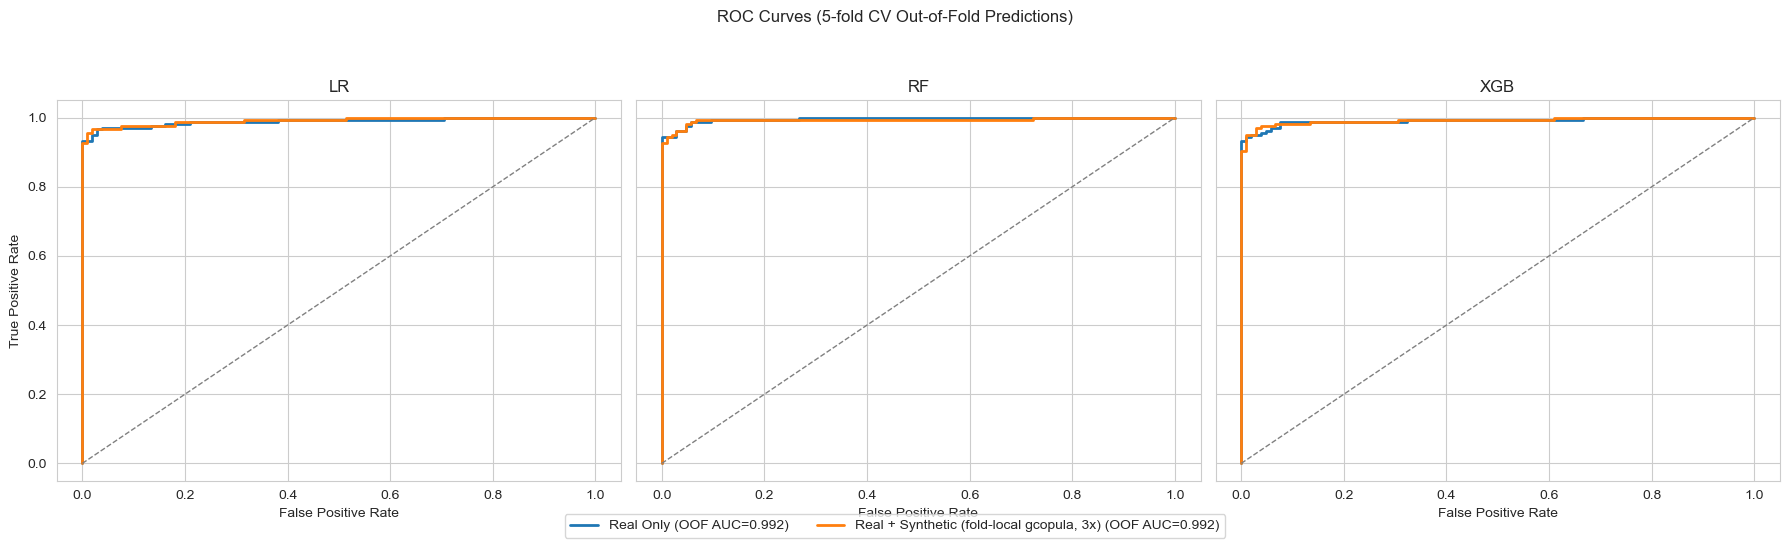

In [12]:
n = len(MODEL_NAMES)
fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)
if n == 1:
    axes = [axes]

handles, labels = None, None
for ax, model_name in zip(axes, MODEL_NAMES):
    for scenario in SCENARIOS:
        info = roc_data[(model_name, scenario)]
        ax.plot(
            info['fpr'],
            info['tpr'],
            linewidth=2,
            label=f"{scenario} (OOF AUC={info['auc']:.3f})",
        )
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)
    ax.set_title(model_name.upper())
    ax.set_xlabel("False Positive Rate")
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
axes[0].set_ylabel("True Positive Rate")

fig.suptitle("ROC Curves (5-fold CV Out-of-Fold Predictions)", y=1.05)
if handles and labels:
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout()
plt.show()

## 12. Plot 3: Side-by-Side Confusion Matrices (CV Out-of-Fold Predictions)


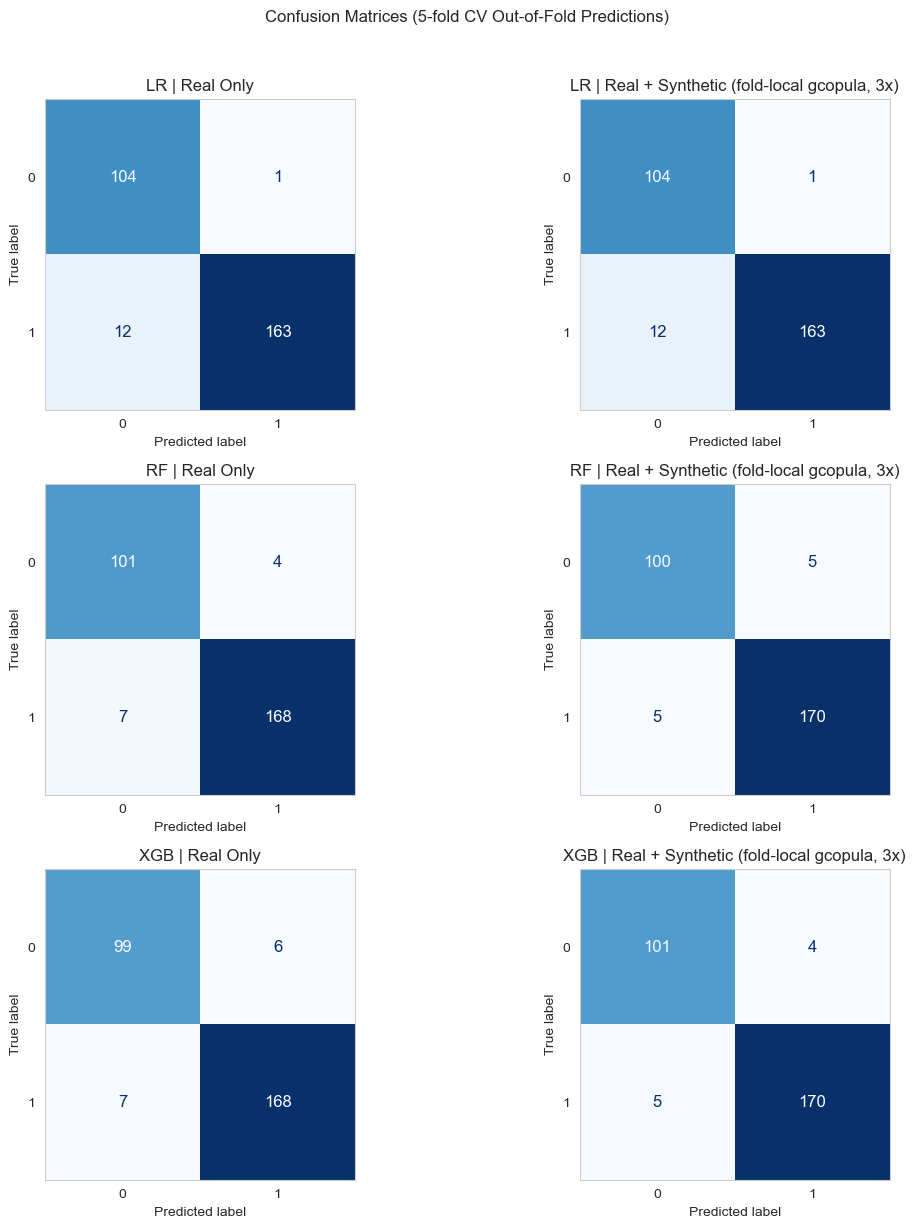

In [13]:
n = len(MODEL_NAMES)
fig, axes = plt.subplots(n, 2, figsize=(12, 4 * n))
if n == 1:
    axes = np.array([axes])

for i, model_name in enumerate(MODEL_NAMES):
    for j, scenario in enumerate(SCENARIOS):
        ax = axes[i, j]
        cm = oof_results[(model_name, scenario)]['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False, text_kw={'fontsize': 12})
        ax.set_title(f"{model_name.upper()} | {scenario}")
        ax.grid(False)

fig.suptitle("Confusion Matrices (5-fold CV Out-of-Fold Predictions)", y=1.02)
plt.tight_layout()
plt.show()